# Save and load data
## read_mat_data: Loads a single .mat file
 - Input: path of file
 - Output: numpy.ndarray

In [1]:
def read_mat_data(recordName):
    import scipy.io
    return scipy.io.loadmat(recordName)['val'][0]

## split_data: split record at heart beats
It finds R peaks and splits recording at R peaks to get a list of recording of single heart beats

In [2]:
def split_data(input):
    import numpy as np
    import rpeakdetect as rpd # detecting beats (R peak) (https://github.com/tru-hy/rpeakdetect)
    peaks = rpd.detect_beats(input, 300)
    return np.split(mat, peaks)

## read_class: Read annotation for recordings
It loads class names for each recordings and returns a dict that has keys of filenames and values of names of classes

In [3]:
def read_class():
    import csv
    reader = csv.reader( open("REFERENCE.csv") )
    classNames = {}
    for row in reader:
        classNames[ row[0] ] = row[1]
    return classNames

## read_pkl_data: Loads preprepared data file

In [4]:
def read_pkl_data():
    import pickle
    with open("data.pkl", "rb") as f:
        return pickle.load(f)

## convert: Combine .mat and csv files into a single pickle file
It loads all recordings and their annotation (names of classes: N, A, O, ~), stores in a dict that has keys of class names and values of list of corresponding recordings and saves in a pickle file

In [5]:
def convert():
    import pickle
    import glob, os # listing all files
    os.chdir("training2017/")
    files = glob.glob("*.mat")

    classNames = read_class()
    data = {}
    data["N"] = data["A"] = data["O"] = data["~"] = []

    for i, file in enumerate(files):
        data[ classNames[ os.path.splitext(file)[0] ] ].append( read_mat_data(file) )
        print( i+1, len(files) )

    os.chdir("../")
    pickle.dump( data, open( "data.pkl", "wb" ) )

# SQL database

## save2db: save .mat files merged with content of the csv file to an sqLite3 database
Database is needed for visualisation of recordings for manual classification

In [6]:
def save2db():
    import sqlite3, os, csv, scipy.io
    conn = sqlite3.connect('AFchallenge')
    c = conn.cursor()
    c.execute("DELETE FROM recordings")
    os.chdir("training2017/")
    reader = csv.reader( open("REFERENCE.csv") )
    
    data = []
    for i,row in enumerate(reader):
        recording = scipy.io.loadmat(row[0] + ".mat")['val'][0]
        data.append((",".join(map(str,recording)),
                     "official", 
                     row[1], 
                     row[0]))
        print(i)
    c.executemany(
        "INSERT INTO recordings (data, source, class, name) VALUES (?, ?, ?, ?)", data)
    conn.commit()
    os.chdir("../")

## sqlQuery: add or get data from database on the server 'users'
e.g. sending the classification result of our neural network upon the class of a given recording: *UPDATE recordings SET machine_guess = "N" WHERE name = "A00002"*
 - Input: SQL statement
 - Output: list of dictionaries containing result of the query (dictionaries of list are the rows of result, keys of dictionaries are names of selected attributes of the query)

In [7]:
def sqlQuery(sql):
    import requests
    r = requests.post("https://users.itk.ppke.hu/~hakta/challenge/query.php", 
                      data = {'password': "qVK0fFt6zKLH{6T", 'sql': sql})
    if r.status_code != requests.codes.ok:
        raise Exception("ERROR " + str(r.status_code) + ": " + r.reason)
    else:
        try:
            resp = r.json()
            if resp["error"] != "OK":
                raise Exception(resp["error"][2])
            return resp["data"]
        except ValueError:
            print(r.text)

In [8]:
# sqlQuery("SELECT * FROM recordings WHERE rec_ID = 2 OR rec_ID = 1") # Example

# Resampling - Augmentation

## resample: streches the recording by on timescale resampling it

In [9]:
from scipy import signal
def resample(data, old_to_new_ratio):
    return signal.resample(data, round(len(data)/old_to_new_ratio))

# Visualization

## plot: plotting a line chart with real time axis

In [10]:
#import pandas
#%matplotlib inline
import matplotlib.pyplot as plt

def plot(sample):
    x = np.linspace(0, len(sample)/300, len(sample), endpoint=False)
    y = sample
    plt.plot(x, y)

## Example code on visualizing data and its augmentation

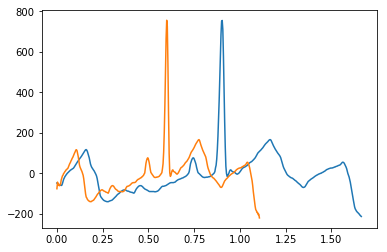

In [11]:
import matplotlib.pyplot as plt
import numpy as np
data = read_pkl_data()
example = data["N"][1][500:1000]
plt.figure(1)
plot(example)
plt.figure(1)
plot(resample(example, 1.5))
plt.show()